In [1]:
import torch
from torch import nn
import sys
sys.path.append(r'C:\Users\geass\Hierarchical_Attention_Networks_for_Document_Classification')
from models.HAN import HAN
from utils import preprocessing as pp

import pandas as pd
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\geass\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv(r'C:\Users\geass\Hierarchical_Attention_Networks_for_Document_Classification\data\Amazon_reviews_polarity\train.csv')
df.head(10)

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
5,1,Buyer beware,"This is a self-published book, and if you want..."
6,2,Glorious story,I loved Whisper of the wicked saints. The stor...
7,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
8,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...
9,1,The Worst!,A complete waste of time. Typographical errors...


In [3]:
df.columns = ['polarity', 'title', 'review']
df = df.sample(n=10000, random_state=42)
df['review'] = df['title'].astype(str) + '. ' + df['review'].astype(str)
df = df.drop('title', axis=1)
df.head(10)

,polarity,review
3493923,2,Very disappointed. My son got this toy for his...
2472516,1,Doesn't help with cats or dogs!. A person I wo...
2110064,1,Don't waste your money on this DVD. This DVD i...
2762210,1,EZEKIEL 13. Mr. Spong has attempted to reduce ...
1438189,1,Won't fit your case.. I am the fourth review a...
2944011,1,Book reads like written for grade schoolers. I...
2434835,1,HUGE KID ROCK FAN ~ SO DISAPPOINTED!. I own al...
2588667,2,Structured and diverse studio release. Excelle...
2464250,1,A master of economics. Sean proves at least on...
218313,2,"Slow at first, picks up as it goes along, good..."


In [4]:
df_train = df.sample(n=8000, random_state=42)
print(df_train.shape)

df_train_index = df_train.index
df = df.drop(df_train_index)
df_valid = df.sample(n=1000, random_state=42)
print(df_valid.shape)

df_valid_index = df_valid.index
df_test = df.drop(df_valid_index)
print(df_test.shape)

y_train = torch.tensor(df_train['polarity'].map(lambda x: 0 if x==1 else 1).to_numpy(), dtype=torch.long)
y_valid = torch.tensor(df_valid['polarity'].map(lambda x: 0 if x==1 else 1).to_numpy(), dtype=torch.long)
y_test = torch.tensor(df_test['polarity'].map(lambda x: 0 if x==1 else 1).to_numpy(), dtype=torch.long)
print(y_train.shape, y_valid.shape, y_test.shape)

num_classes = len(torch.unique(y_train))

(8000, 2)
(1000, 2)
(1000, 2)
torch.Size([8000]) torch.Size([1000]) torch.Size([1000])


In [5]:
tokenized_train = pp.tokenize_docs(df_train)
tokenized_valid = pp.tokenize_docs(df_valid)
tokenized_test = pp.tokenize_docs(df_test)
print("Tokenized shapes:", len(tokenized_train), len(tokenized_valid), len(tokenized_test))

Tokenized shapes: 8000 1000 1000


In [6]:
vocabulary, word_count = pp.build_vocabulary(tokenized_train)

tokenized_train = pp.replace_unk(tokenized_train, word_count)
tokenized_valid = pp.replace_unk(tokenized_valid, word_count)
tokenized_test = pp.replace_unk(tokenized_test, word_count)

max_sentence_len = pp.max_sentence_length(tokenized_train)
max_document_len = pp.max_document_length(tokenized_train)

tokenized_train = pp.insert_padding(tokenized_train, max_sentence_len, max_document_len)
tokenized_valid = pp.truncate(tokenized_valid, max_sentence_len, max_document_len)
tokenized_valid = pp.insert_padding(tokenized_valid, max_sentence_len, max_document_len)
tokenized_test = pp.truncate(tokenized_test, max_sentence_len, max_document_len)
tokenized_test = pp.insert_padding(tokenized_test, max_sentence_len, max_document_len)
print("Tokenized shapes:", len(tokenized_train), len(tokenized_valid), len(tokenized_test))

embedding_matrix = pp.make_embedding_matrix(tokenized_train, vocabulary, embedding_size=100)
x_train = pp.word_to_indices(tokenized_train, vocabulary)
x_valid = pp.word_to_indices(tokenized_valid, vocabulary)
x_test = pp.word_to_indices(tokenized_test, vocabulary)
print("X shapes:", x_train.shape, x_valid.shape, x_test.shape)

Tokenized shapes: 8000 1000 1000
X shapes: torch.Size([8000, 25, 205]) torch.Size([1000, 25, 205]) torch.Size([1000, 25, 205])


In [7]:
from torch.utils.data import Dataset, DataLoader

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, docs, labels):
        self.docs = docs
        self.labels = labels
    
    def __len__(self):
        return len(self.docs)
    
    def __getitem__(self, idx):
        return self.docs[idx], self.labels[idx]

In [9]:
train_set = ReviewDataset(x_train, y_train)
train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, pin_memory=True)

valid_set = ReviewDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_set, batch_size=256, pin_memory=True)

test_set = ReviewDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size=256, pin_memory=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
def train_model(model_class, model_kwargs, dataloader, criterion, optimizer_class, lr, device, epochs):
    model = model_class(**model_kwargs).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            output = model(x)
            loss = criterion(output, y)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss per Epoch")
    plt.show()

    return model

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

In [13]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            y_pred.extend(output.argmax(dim=1).cpu().tolist())
            y_true.extend(y.cpu().tolist())
            loss = criterion(output, y)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    cm_display.plot()
    plt.title("Confusion Matrix")
    plt.show()

    return

In [14]:
def lr_grid_search(model_class, model_kwargs, learning_rates, dataloader, criterion, optimizer_class, device, epochs):

    for lr in learning_rates:
        print(f"=============Learning rate: {lr}===========")
        model = train_model(model_class, model_kwargs, dataloader, criterion, optimizer_class, lr, device, epochs)
        evaluate_model(model, valid_dataloader, criterion, device)

=============Learning rate: 0.05===========
Epoch 1/5, Loss: 0.7920
Epoch 2/5, Loss: 0.6458
Epoch 3/5, Loss: 0.4937
Epoch 4/5, Loss: 0.4550
Epoch 5/5, Loss: 0.3972


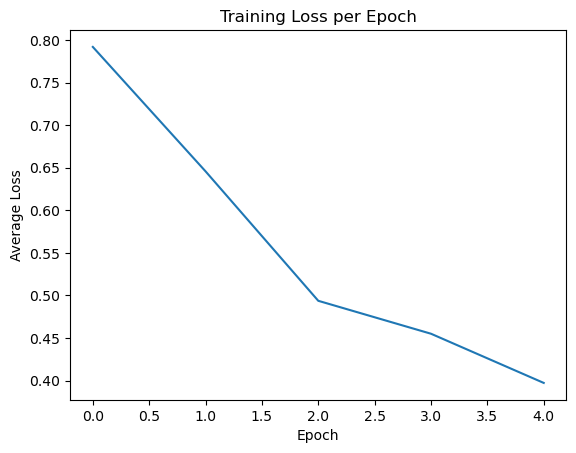

Accuracy: 0.7370, Loss: 0.5142, F1 Score: 0.7687


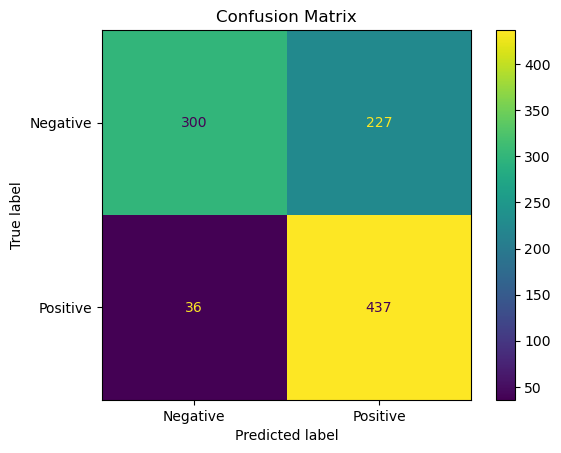

=============Learning rate: 0.01===========
Epoch 1/5, Loss: 0.6246
Epoch 2/5, Loss: 0.4391
Epoch 3/5, Loss: 0.3579
Epoch 4/5, Loss: 0.3136
Epoch 5/5, Loss: 0.2753


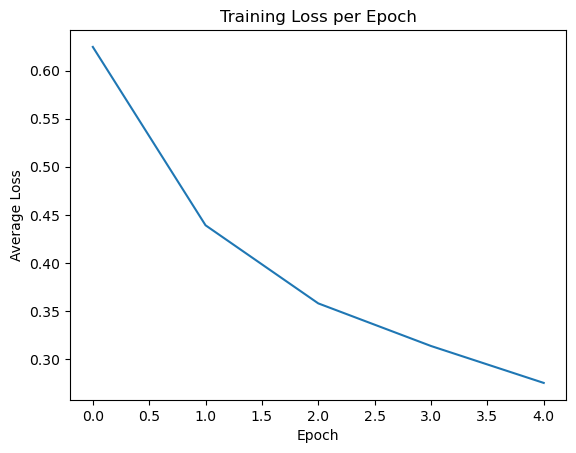

Accuracy: 0.8530, Loss: 0.3028, F1 Score: 0.8458


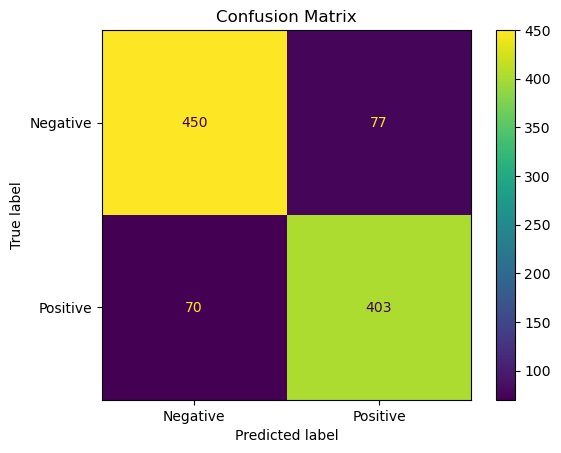

=============Learning rate: 0.005===========
Epoch 1/5, Loss: 0.6496
Epoch 2/5, Loss: 0.5031
Epoch 3/5, Loss: 0.4125
Epoch 4/5, Loss: 0.3567
Epoch 5/5, Loss: 0.3132


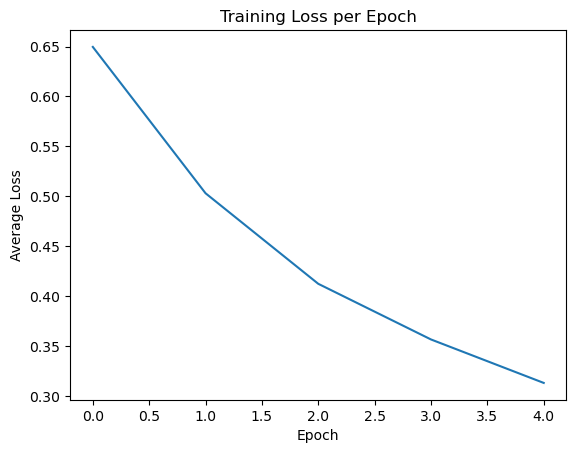

Accuracy: 0.8260, Loss: 0.4134, F1 Score: 0.8337


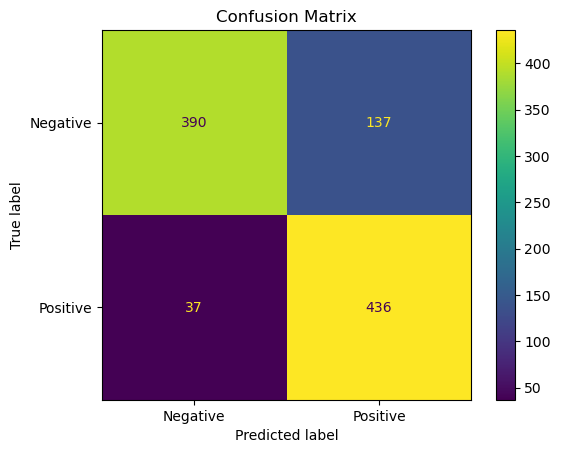

=============Learning rate: 0.001===========
Epoch 1/5, Loss: 0.6868
Epoch 2/5, Loss: 0.6051
Epoch 3/5, Loss: 0.5148
Epoch 4/5, Loss: 0.4537
Epoch 5/5, Loss: 0.3970


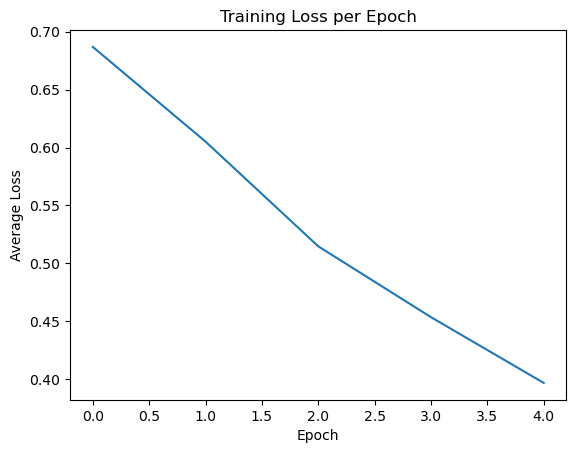

Accuracy: 0.8150, Loss: 0.4011, F1 Score: 0.8126


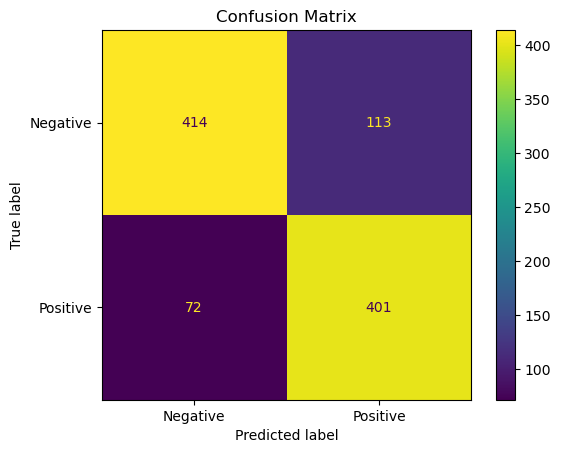

=============Learning rate: 0.0005===========
Epoch 1/5, Loss: 0.6850
Epoch 2/5, Loss: 0.6138
Epoch 3/5, Loss: 0.5209
Epoch 4/5, Loss: 0.4724
Epoch 5/5, Loss: 0.4393


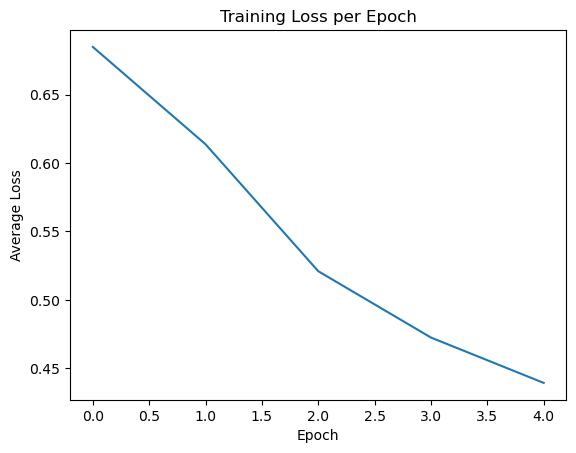

Accuracy: 0.7950, Loss: 0.4334, F1 Score: 0.7817


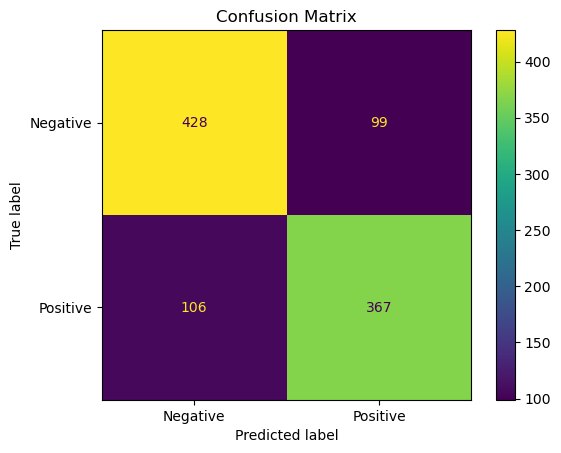

=============Learning rate: 0.0001===========
Epoch 1/5, Loss: 0.7039
Epoch 2/5, Loss: 0.6913
Epoch 3/5, Loss: 0.6856
Epoch 4/5, Loss: 0.6729
Epoch 5/5, Loss: 0.6454


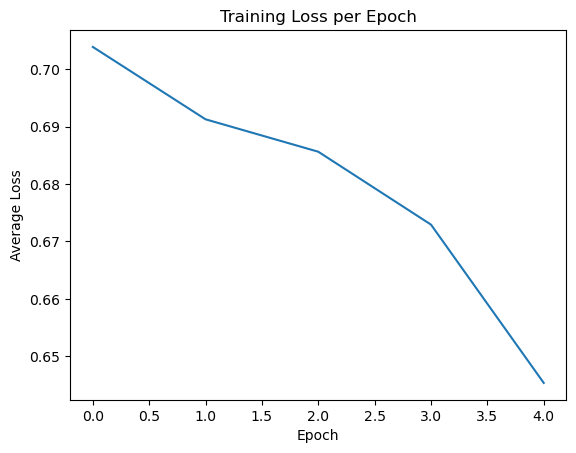

Accuracy: 0.6540, Loss: 0.6312, F1 Score: 0.6448


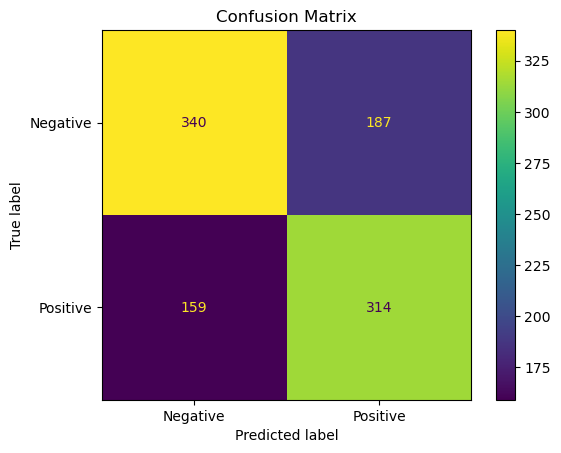

In [15]:
lrs = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
model_kwargs = {
    'embedding_matrix': embedding_matrix,
    'hidden_size': 25,
    'output_size': num_classes
}

criterion = nn.NLLLoss()
optimizer_class = torch.optim.Adam

lr_grid_search(model_class=HAN, model_kwargs=model_kwargs, learning_rates=lrs, dataloader=train_dataloader, criterion=criterion, optimizer_class=optimizer_class, device=device, epochs=5)

Na osnovu prikazanih grafika i metrika možemo da zaključimo da se learning rate od 0.01 pokazao najbolje. Konvergira dovoljno brzo na početku ali ne gubi na tačnosti vremenom. Naravno idealno bi bilo da se lr menja tj smanjuje vremenom kako bi loss funkcija još bolje iskonvergirala.

Epoch 1/15, Loss: 0.6477
Epoch 2/15, Loss: 0.4824
Epoch 3/15, Loss: 0.3965
Epoch 4/15, Loss: 0.3461
Epoch 5/15, Loss: 0.3042
Epoch 6/15, Loss: 0.2646
Epoch 7/15, Loss: 0.2460
Epoch 8/15, Loss: 0.2204
Epoch 9/15, Loss: 0.2007
Epoch 10/15, Loss: 0.1733
Epoch 11/15, Loss: 0.1879
Epoch 12/15, Loss: 0.1601
Epoch 13/15, Loss: 0.1705
Epoch 14/15, Loss: 0.1423
Epoch 15/15, Loss: 0.1163


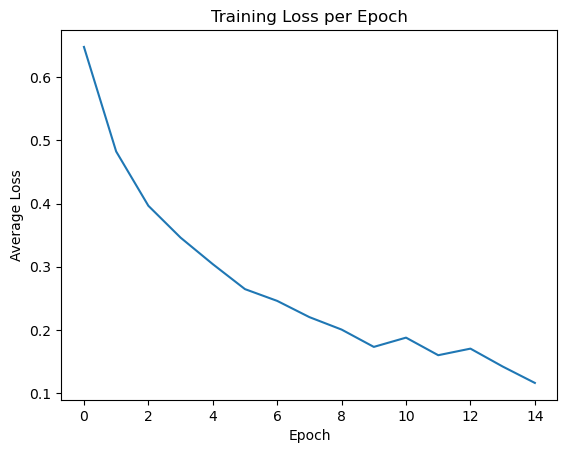

In [16]:
lr=0.01
trained_model = train_model(model_class=HAN, model_kwargs=model_kwargs, dataloader=train_dataloader, criterion=criterion, optimizer_class=optimizer_class, lr=lr, device=device, epochs=15)

Možemo primetiti da je negde oko 10-te epohe loss počeo da ima fluktuacije mada je na kraju uspeo da se dodatno spusti. Ove fluktuacije potvrđuju gornju primedbu da govore nam da bi verovatno negde oko 10-te epohe mogli da smanjim lr kako bismo dodatno optimizovali konvergenciju.

Accuracy: 0.8450, Loss: 0.4431, F1 Score: 0.8511


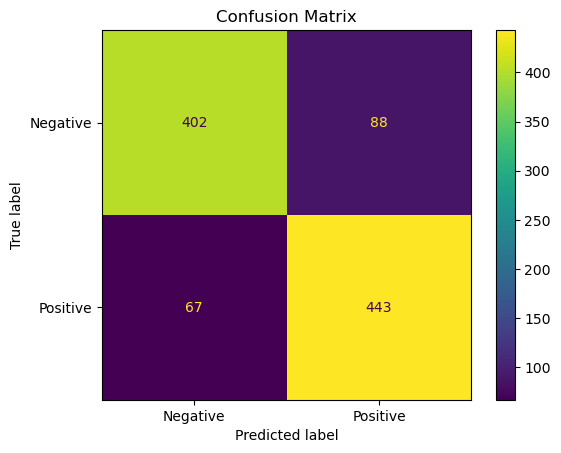

In [17]:
evaluate_model(model=trained_model, dataloader=test_dataloader, criterion=criterion, device=device)

Accuracy: 0.9724, Loss: 0.0889, F1 Score: 0.9723


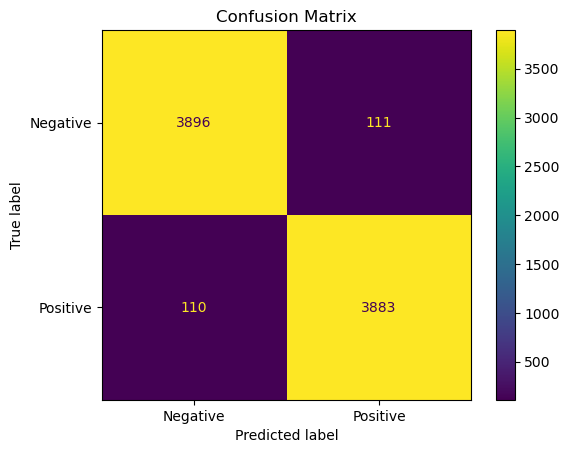

In [18]:
evaluate_model(model=trained_model, dataloader=train_dataloader, criterion=criterion, device=device)

Kao što vidimo model pogadja u oko 84.5% slučajeva. Ono što je lepo jeste što je i f1 score blizu 1 što znači da model nije samo dobar u pogadjanju jedne brojnije klase, mada se i kratkim pogledom na skup može videti da je relativno izbalansiran. Zbog same veličine trening skupa (8000 nasparm 3.6M originalnog) ovaj model je dosta jednostavniji te je rezultat nakon 15 epohi ne preterano bolji od onog nakon 5. Međutim vidimo i da model donekle overfittuje što je opet zbog njegove jednostavnosti i možda za takav model prevelikog broja epoha. Dakle možda bi trebalo da se smanji broj epohi na 10ak kako bi se ovo izbeglo